In [10]:
!pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit4/requirements-unit4.txt

  Cloning https://github.com/ntasfi/PyGame-Learning-Environment.git to /tmp/pip-req-build-x4sozi9u
  Running command git clone --filter=blob:none --quiet https://github.com/ntasfi/PyGame-Learning-Environment.git /tmp/pip-req-build-x4sozi9u
  Resolved https://github.com/ntasfi/PyGame-Learning-Environment.git to commit 3dbe79dc0c35559bb441b9359948aabf9bb3d331
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/simoninithomas/gym-games to /tmp/pip-req-build-iu1olow3
  Running command git clone --filter=blob:none --quiet https://github.com/simoninithomas/gym-games /tmp/pip-req-build-iu1olow3
  Resolved https://github.com/simoninithomas/gym-games to commit f31695e4ba028400628dc054ee8a436f28193f0b
  Preparing metadata (setup.py) ... done


# Q-Learning on the CartPole Environment

This is an altered version of Jose Nieves Flores Maynez' notebook.

This tutorial shows how to use Q-Learning to train an RL agent on the CartPole-v0 task from the [OpenAI Gym](https://gym.openai.com/).

![cartpole](https://github.com/pytorch/tutorials/blob/main/_static/img/cartpole.gif?raw=true)

The Cartpole environment is a common simple example that is used often for simple RL examples.

In this environment, the task is to balance the pole that is attached to the cart, by moving the cart to either side.
The reward gets incremented for each step (for up to 500 steps => cartpole-v1 max steps = 500 NOT 200!! ref:https://www.gymlibrary.dev/environments/classic_control/cart_pole/) where the pole is not exceeding a set angle and the cart is not touching the sides of the line.
The environment provides four parameters that represent the state of the environment:
Position and velocity of the cart and angle and angular velocity of the pole (see [the documentation](https://gymnasium.farama.org/environments/classic_control/cart_pole/#observation-space)).
We will solve this by applying Q-Learning to our RL agent.


### Packages


First, let's import needed packages.

In [11]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange, tqdm
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Gym
import gym
import gym_pygame

# Hugging Face Hub
from huggingface_hub import notebook_login # To log to our Hugging Face account to be able to upload models to the Hub.
import imageio

## Check if we have a GPU

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Implementation
Since this algorithm relies on updating a function for each existing pair of state and action, environments that have a high state-space become problematic. This is because we can approximate better the actual value of a state-action pair as we visit it more often. However, if we have many states or many actions to take, we distribute our visits among more pairs and it takes much longer to converge to the actual true values. The CartPole environment gives us the position of the cart, its velocity, the angle of the pole and the velocity at the tip of the pole as descriptors of the state. However, all of these are continuous variables. To be able to solve this problem, we need to discretize these states since otherwise, it would take forever to get values for each of the possible combinations of each state, despite them being bounded. The solution is to group several values of each of the variables into the same “bucket” and treat them as similar states. The agent implemented for this problem uses 3, 3, 6, and 6 buckets respectively.

In [13]:
env = gym.make("CartPole-v1")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 100	Average Score: 33.74
Episode 200	Average Score: 133.45
Episode 300	Average Score: 234.47
Episode 400	Average Score: 432.10
Episode 500	Average Score: 497.20
Episode 600	Average Score: 445.54
Episode 700	Average Score: 491.06
Episode 800	Average Score: 429.72
Episode 900	Average Score: 437.10
Episode 1000	Average Score: 499.53


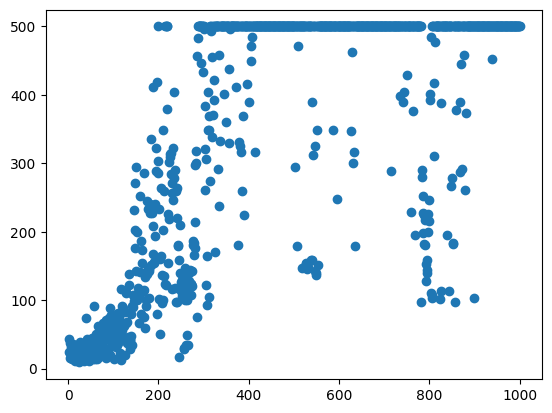

In [25]:
class ReinforceAgent(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        """
        Initialize agent.

        :param s_size: The size of the state vector
        :param a_size: The size of the action vector
        :param h_size: The size of the hidden state vector
        """
        super(ReinforceAgent, self).__init__()
        # TODO: Create two fully connected layers
        self.inputLayer = nn.Linear(s_size, h_size) # Input Layer
        self.fc1 = nn.ReLU()
        self.hidden1 = nn.Linear(h_size, h_size) # Hidden Layer 1
        self.fc2 = nn.ReLU()
        self.hidden2 = nn.Linear(h_size, a_size) # Hidden Layer 2
        self.fcOutput = nn.Softmax()


    def forward(self, x):
        # TODO: Define the forward pass
        # state goes to fc1 then we apply ReLU activation function
        x = self.fc1(self.inputLayer(x))
        # fc1 outputs goes to fc2
        x = self.fc2(self.hidden1(x))
        # We output the softmax
        x = self.fcOutput(self.hidden2(x))
        return x

    def act(self, state):
        """
        Given a state, take action
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        # print(f"here are the probs: \n{probs}")
        m = Categorical(probs)
        # print(f"strange m: {m}")
        action = m.sample()
        return action.item(), m.log_prob(action)

def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []

    steps = 0
    steps_to_episode = []

    for i_episode in trange(1, n_training_episodes + 1):
        saved_log_probs = []
        rewards = []
        state = env.reset()

        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            steps += 1
            if done:
                break
        steps_to_episode.append((i_episode, steps))
        steps = 0
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        returns = deque(maxlen=max_t)
        n_steps = len(rewards)
        # Compute the discounted returns at each timestep,
        # as the sum of the gamma-discounted return at time t (G_t) + the reward at time t
        #
        # In O(N) time, where N is the number of time steps
        # (this definition of the discounted return G_t follows the definition of this quantity
        # shown at page 44 of Sutton&Barto 2017 2nd draft)
        # G_t = r_(t+1) + r_(t+2) + ...

        # Given this formulation, the returns at each timestep t can be computed
        # by re-using the computed future returns G_(t+1) to compute the current return G_t
        # G_t = r_(t+1) + gamma*G_(t+1)
        # G_(t-1) = r_t + gamma* G_t
        # (this follows a dynamic programming approach, with which we memorize solutions in order
        # to avoid computing them multiple times)

        # This is correct since the above is equivalent to (see also page 46 of Sutton&Barto 2017 2nd draft)
        # G_(t-1) = r_t + gamma*r_(t+1) + gamma*gamma*r_(t+2) + ...

        ## Given the above, we calculate the returns at timestep t as:
        #               gamma[t] * return[t] + reward[t]
        #
        ## We compute this starting from the last timestep to the first, in order
        ## to employ the formula presented above and avoid redundant computations that would be needed
        ## if we were to do it from first to last.

        ## Hence, the queue "returns" will hold the returns in chronological order, from t=0 to t=n_steps
        ## thanks to the appendleft() function which allows to append to the position 0 in constant time O(1)
        ## a normal python list would instead require O(N) to do this.
        for t in range(n_steps)[::-1]:
            disc_return_t = returns[0] if len(returns) > 0 else 0
            returns.appendleft(gamma * disc_return_t + rewards[t])

        ## standardization of the returns is employed to make training more stable
        eps = np.finfo(np.float32).eps.item()
        ## eps is the smallest representable float, which is
        # added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        policy_loss = []
        # Here the loss function is calculated => same equation as in lecture => update after whole trajectory as REINFROCE is a MC approach
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        optimizer.zero_grad()
        # Here the backpropagation is calculated with respect to the above defined loss function
        policy_loss.backward()
        # Here the NN updates the parameters theta
        optimizer.step()

        if i_episode % print_every == 0:
            tqdm.write("Episode {}\tAverage Score: {:.2f}".format(i_episode, np.mean(scores_deque)))

        # print(f"steps_to_episode: \n{steps_to_episode}")

    x = [item[0] for item in steps_to_episode]
    y = [item[1] for item in steps_to_episode]
    plt.scatter(x, y)
    plt.show()
    return scores


cartpole_hyperparameters = {
    "h_size": 64,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 0.99,
    "lr": 1e-3,
    "state_space": env.observation_space.shape[0],
    "action_space": env.action_space.n,
}


def load_reinforce_agent():
    cartpole_policy = ReinforceAgent(
        cartpole_hyperparameters["state_space"],
        cartpole_hyperparameters["action_space"],
        cartpole_hyperparameters["h_size"],
    ).to(device)
    cartpole_optimizer = optim.Adam(cartpole_policy.parameters(), lr=cartpole_hyperparameters["lr"])
    scores = reinforce(
        cartpole_policy,
        cartpole_optimizer,
        cartpole_hyperparameters["n_training_episodes"],
        cartpole_hyperparameters["max_t"],
        cartpole_hyperparameters["gamma"],
        100,
    )
    return cartpole_policy

agent = load_reinforce_agent()

In [26]:
def plot_learning(stepsPerEpisode: int, n_eval_episodes: int) -> None:
  plt.scatter(n_eval_episodes, stepsPerEpisode)
  plt.show()

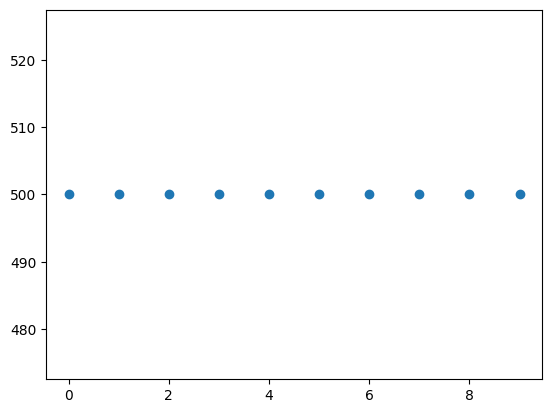

(500.0, 0.0)

In [27]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
    """
    Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
    :param env: The evaluation environment
    :param n_eval_episodes: Number of episode to evaluate the agent
    :param policy: The Reinforce agent
    """
    # For plotting the steps per episode:
    stepsPerEpisode = []
    totalSteps = 0

    episode_rewards = []
    for episode in range(n_eval_episodes):
        state = env.reset()
        step = 0
        done = False
        total_rewards_ep = 0

        totalSteps = 0

        for step in range(max_steps):
            action, _ = policy.act(state)
            new_state, reward, done, info = env.step(action)
            total_rewards_ep += reward
            totalSteps += 1

            if done:
                break
            state = new_state
        stepsPerEpisode.append(totalSteps)
        episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    plot_learning(stepsPerEpisode, range(n_eval_episodes))

    return mean_reward, std_reward

evaluate_agent(
    env, cartpole_hyperparameters["max_t"], cartpole_hyperparameters["n_evaluation_episodes"], agent
)

**Observations**

As we can see the model fully converged to the maximum of 500 (for the reward). Furthermore we have a standart deviation of 0.0!